In [2]:
from matplotlib import pyplot as plt
import numpy as np

[ 000000.00 ]   0: 11-04 15:06  Hmf             INFO     Logger initialized at level: 20
[ 000000.00 ]   0: 11-04 15:06  Hmf             INFO     MPI_COMM_WORLD | size = 1 -- Nbkit COMM | size = 1
[ 000000.06 ]   0: 11-04 15:06  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000000.65 ]   0: 11-04 15:06  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000000.70 ]   0: 11-04 15:06  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000001.02 ]   0: 11-04 15:06  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000001.64 ]   0: 11-04 15:06  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000001.69 ]   0: 11-04 15:06  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000002.01 ]   0: 11-04 15:06  CatalogSource   INFO     Extra arguments to FileType: () {'dataset': 'FOFGroups'}
[ 000

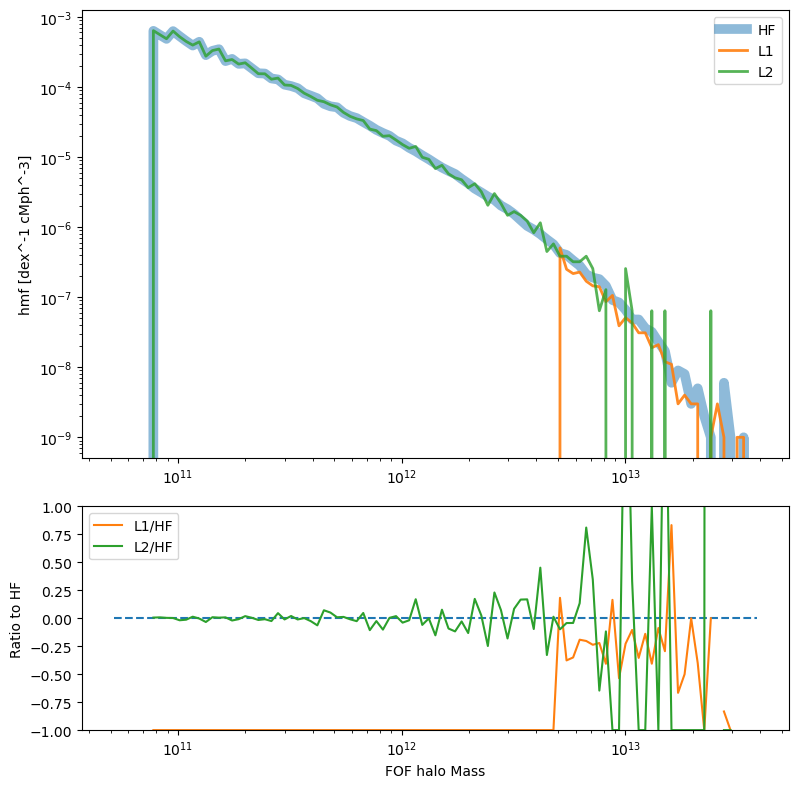

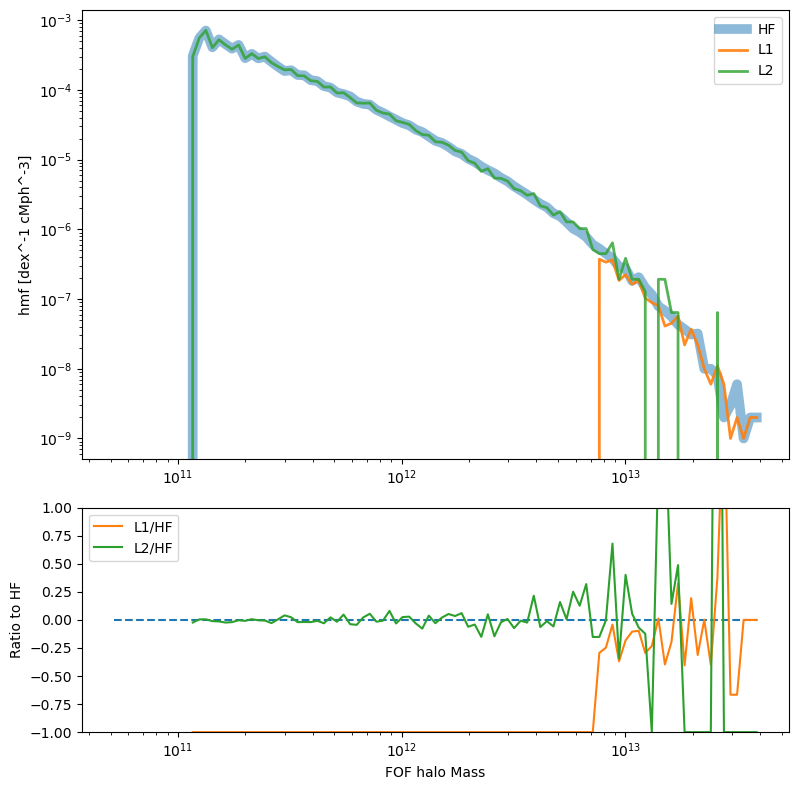

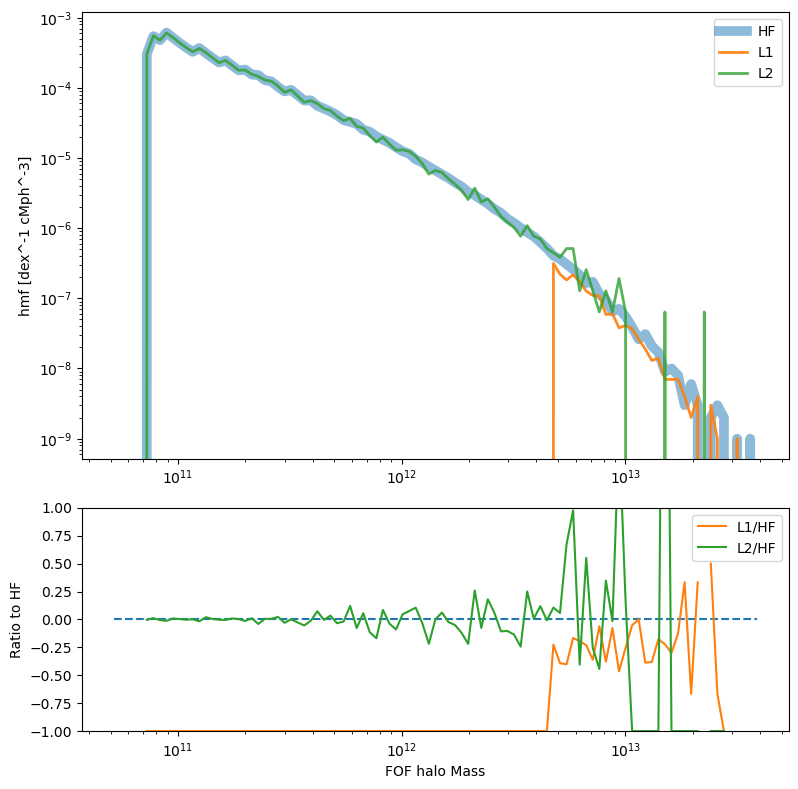

In [19]:
import hmf

hmf = hmf.Hmf()
nums = ['0024', '0026', '0072']
bins = np.logspace(np.log10(5e10), np.log10(4e13), 100)
for n in nums:
    pig_dirs = [f'/scratch/06536/qezlou/Goku/FOF/HF/cosmo_10p_Box1000_Part3000_{n}/output/PIG_003/',
                f'/scratch/06536/qezlou/Goku/FOF/L1/cosmo_10p_Box1000_Part750_{n}/output/PIG_003/',
                f'/scratch/06536/qezlou/Goku/FOF/L2/cosmo_10p_Box250_Part750_{n}/output/PIG_003/']
    vol = {'HF':1000**3, 'L1':1000**3, 'L2':250**3}
    
    labels = ['HF', 'L1', 'L2']
    lws = [7, 2, 2]
    alphas = [0.5, 0.9, 0.8]
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})
    psi = {}
    psi_mbins = {}
    for i in range(3):
        hist = hmf.get_fof_hmf(pig_dirs[i], bins=bins)
        psi[labels[i]] = hist[1]/vol[labels[i]]
        psi_mbins[labels[i]] = hist[0]
        ax[0].plot(psi_mbins[labels[i]], psi[labels[i]], label=labels[i], lw=lws[i], alpha=alphas[i])
        
    ax[1].plot(psi_mbins['HF'], np.zeros_like(psi_mbins['HF']), ls='dashed')
    ax[1].plot(psi_mbins['L1'], psi['L1']/psi['HF'] -1, label='L1/HF')
    ax[1].plot(psi_mbins['L2'], psi['L2']/psi['HF'] -1, label='L2/HF')
    ax[1].set_ylim((-1,1))
    for i in range(2):
        ax[i].set_xscale('log')
        ax[i].legend()
    ax[0].set_yscale('log')
    ax[1].set_xlabel('FOF halo Mass')
    ax[0].set_ylabel('hmf [dex^-1 cMph^-3]')
    ax[1].set_ylabel('Ratio to HF')
    fig.tight_layout()


